<a href="https://colab.research.google.com/github/quanvu0996/TF_cert_training/blob/main/v2_2_ML20M_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import psutil
# gives a single float value
print(psutil.cpu_percent())
# gives an object with many fields
print(psutil.virtual_memory())
# you can convert that object to a dictionary print(dict(psutil.virtual_memory()._asdict()))
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

9.6
svmem(total=13617737728, available=12735361024, percent=6.5, used=623497216, free=12524806144, active=641208320, inactive=293289984, buffers=35926016, cached=433508352, shared=1249280, slab=99827712)
6.5
93.52038700095018


In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import gc

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

In [3]:
tf.__version__

'2.8.0'

In [4]:
itemCol = 'movieId'
userCol = 'userId'

In [5]:
# DGX setup
# fpath = "./ml-20m" 

#colab setup
from google.colab import drive
drive.mount('/content/gdrive')
fpath = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Loading data
ratings = pd.read_csv(fpath+'/ratings.csv')

ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


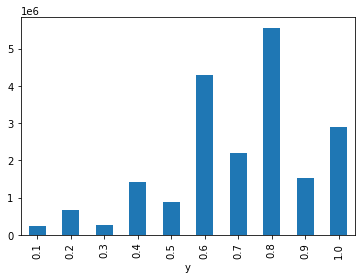

In [7]:
# Normalize rating về dạng -1 -> 1 (-1 = ghét, 1 = thích)
ratings["y"] = ratings["rating"]/5

# Kiểm tra rating trong khoảng -1 -> 1
ratings.groupby("y")["y"].count().plot(kind='bar')

# Model v2.2
Gộp tất cả các bước tiền xử lý vào model 

In [8]:
# Chia dữ liệu thành các tập cho model clustering, nhãn recommendation và test
#     warm_up_mask: ratings đã quan sát
#     target: rating dùng để đánh giá kết quả recommend của module recommend cho từng người dùng
#     test: đánh giá độc lập
# TODO: chia tập dữ liệu theo user-wise => đánh giá với những user hoàn toàn mới thì model có học được không?
# v2.1. gộp warm_up và mask thành 1
def dataset_split(ratings):
    train, test = train_test_split(ratings, test_size= 0.25)
    warm_up_mask, target = train_test_split(train, test_size= 0.25)
    return warm_up_mask, target, test

warm_up_mask, target, test = dataset_split(ratings)

In [9]:
# Kiểm tra số lượng ratings
warm_up_mask.shape[0], target.shape[0], test.shape[0]

(11250147, 3750050, 5000066)

In [10]:
# v2.2: chỉ groupby, không padding
def get_interaction_set(interaction, max_item = None, top_k_item = None):
    """
    Input:
        interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
        max_item: int: item num limit
    Output:
        df, itemCol: list, y: list, itemCol_str: string, userCol as index
        list item sắp xếp theo giảm dần độ lớn rating
    """
    items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
    if top_k_item is not None:
        top_items = items.head(top_k_item).index
        interaction = interaction[interaction[itemCol].isin(top_items)]
    else:
        top_items = items.index

    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    interaction = interaction.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    interaction = interaction.groupby("userId").agg({itemCol:list, "y":list})

    # Giới hạn độ dài warm_up size
    if max_item is not None:
        interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
        interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])

    return interaction, top_items

top_k_item = 5000
wu_size = 200
mask_size = 50
max_item = wu_size + mask_size

interac_df, top_items = get_interaction_set(warm_up_mask[warm_up_mask[userCol]<1000]
                    , max_item = max_item
                    , top_k_item = top_k_item )
interac_df

,movieId,y
userId,,
1,"[4993, 7153, 1196, 8636, 318, 2288, 1321, 1079...","[1.0, 1.0, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, ..."
2,"[1196, 3930, 1214, 541, 1210, 1327, 3928, 2948...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,"[1198, 2985, 316, 1831, 1257, 1089, 1097, 1208...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,"[454, 431, 520, 10, 368, 356, 586, 480, 19, 54...","[1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6, ..."
5,"[1291, 440, 589, 1393, 364, 1028, 141, 590, 10...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...
995,"[6618, 6790, 27731, 1199, 3972, 1197, 3819, 48...","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ..."
996,"[296, 50, 357, 356, 47, 25, 597, 292, 539, 477...","[1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, ..."
997,"[58559, 64957, 4226, 3578, 55118, 1089, 7153, ...","[1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ..."


### Class  model

In [11]:
# Khởi tạo cấu hình: xác định encoder, decoder, mapping dims
class Efficient_Rec(tf.keras.Model):
  def __init__(self, encoder, decoder, reps, use_tf_function=False):
    super().__init__()
    self.use_tf_function = use_tf_function

    self.encoder = encoder
    self.decoder = decoder
    self.reps = reps

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [12]:
def _wu_mask_split(self, batch_inputs, mask_ratio = 0.25):
    "Chia ratings và items thành mask, warm up"
    input_items, input_ratings = batch_inputs[itemCol], batch_inputs["y"]

    def list_split(input, mask_ratio = 0.25, seed= 42):
        return train_test_split(input[0:(wu_size+mask_size)], test_size= mask_ratio, random_state=seed)

    seed = random.randint(1, 100)
    items = input_items.apply(lambda x: list_split(x, mask_ratio, seed))
    ratings = input_ratings.apply(lambda x: list_split(x, mask_ratio, seed))

    wu_item_list = items.apply(lambda x: x[0])
    mask_item_list = items.apply(lambda x: x[1])

    wu_rating_list = ratings.apply(lambda x: x[0])
    mask_rating_list = ratings.apply(lambda x: x[1])
    return (wu_item_list, wu_rating_list), (mask_item_list, mask_rating_list)

Efficient_Rec._wu_mask_split = _wu_mask_split

In [13]:
def _preprocess(self, inputs, padding_size = 100):
    """
    Padding về wu_size và mask_size, convert list of items => string of items
    batch_inputs: df: itemStr, y"""

    def padding_list(list_item, wu_size, value=0, is_padding=True):
        series_item1 = list_item[0:wu_size]
        if is_padding:
            series_item1 = series_item1+[value]*(wu_size-len(series_item1))
        return series_item1

    items_list, ratings_list = inputs

    items   = items_list.apply(lambda x: ' '.join(list([str(i) for i in x])))
    ratings =   np.stack( ratings_list.apply(lambda x: padding_list( x, padding_size  ) ) )

    return items, ratings

Efficient_Rec._preprocess = _preprocess

In [14]:
# Thực hiện training
def _train_step(self, inputs):
    warm_up, mask = self._wu_mask_split(inputs, mask_ratio = 0.25)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, mask_size)

    with tf.GradientTape() as tape:
        # Encode the input
        wu_vec = self.encoder([wu_items, wu_ratings])
        y_pred = self.reps(wu_vec)

        # Encde the output
        mask_vec = self.decoder([mask_item, mask_ratings])

        average_loss = self.loss(mask_vec, y_pred)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._train_step = _train_step

In [15]:
# Thực hiện minibatch training
def _batch_train_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    for chunk in chunks:
        self._train_step(chunk)

Efficient_Rec._batch_train_step = _batch_train_step

### Xây dựng encoder model
Encoder =  interaction embedding + user feature embedding<br> 
interaction embedding = sum( interaction embedding các item i)<br> 
interaction embedding item i = rating x (embedding id sản phẩm + embedding item feature)<br>



In [16]:
%%time
# Vectorize (encode + padding) item list
max_vocab_size = len(top_items) # nếu số item có <= top_k_item => lấy số lượng item max
items_str = ' '.join([str(i) for i in top_items])
itemStr = itemCol+"_str"

vectorizer = layers.TextVectorization( max_tokens= top_k_item, split='whitespace', output_sequence_length= wu_size, name = 'vectorizer')
vectorizer.adapt( [items_str] ) 

CPU times: user 235 ms, sys: 29 ms, total: 264 ms
Wall time: 548 ms


In [17]:
class Broadcasting_Multiply(tf.keras.layers.Layer):
    """Nhân 2 layers khác shape với nhau, trong đó:
    inputs=[layer1, layer2]
    layer1.shape = (None, n_item, n_feature)
    layer2.shape = (None, n_item)
    (Chú ý đúng thứ tự)
    """

    def call(self, inputs):
        x, y = inputs

        #we add the extra dimension:
        y = K.expand_dims(y, axis=-1)
        #we replicate the elements
        y = K.repeat_elements(y, rep=x.shape[2], axis=-1)

        return x * y

In [18]:
# Xây dựng mạng
embedding_size = 200
reps_size = 150
cluster_num = 50

def interaction_embedding():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size, output_dim= embedding_size, mask_zero= True, name='ei')(wi)
    wi = layers.Dense(embedding_size, activation='linear', name='di')(wi)

    wr = layers.Input(shape=(wu_size,), name='warm_up_ratings')

    ireps = Broadcasting_Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: K.mean(z, axis=1), name='lambda')(ireps)

    # uprofile = layers.LayerNormalization(name='norm')(uprofile)
    uprofile = layers.Dense( reps_size, activation='linear', name='du')(uprofile)
    uprofile = layers.Dense(cluster_num, activation='sigmoid', name='clustering')(uprofile)
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[uprofile])
    return model

encode_model = interaction_embedding()

In [19]:
# Kiểm tra tham số
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_wi (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 vectorizer (TextVectorization)  (None, 200)         0           ['input_wi[0][0]']               
                                                                                                  
 ei (Embedding)                 (None, 200, 200)     1000000     ['vectorizer[0][0]']             
                                                                                                  
 di (Dense)                     (None, 200, 200)     40200       ['ei[0][0]']                     
                                                                                              

In [20]:
# tf.keras.utils.plot_model( encode_model ,show_shapes=True, show_dtype=True, show_layer_names=True )

### Ground truth
Nhận vào text (gồm các mã id sản phẩm) và ratings => chuyển thành vector theo từng user <br>
Dựng ground trust onehot bằng trung bình rating onehot

In [21]:
%%time
# Vectorize (encode + padding) item list
maskvec = layers.TextVectorization( max_tokens=max_vocab_size, split='whitespace', output_sequence_length= mask_size, name = 'maskvec')
maskvec.adapt( [items_str] ) 

CPU times: user 150 ms, sys: 8.54 ms, total: 159 ms
Wall time: 166 ms


In [22]:
# Xây dựng mạng
def eye_initializer(shape_list, dtype):
    return tf.eye(max_vocab_size)

def mask_label():

    input_mi = layers.Input(shape=(1,), name='input_mask')
    mi = maskvec(input_mi)
    mi = layers.Embedding(input_dim= max_vocab_size, output_dim= max_vocab_size, embeddings_initializer = eye_initializer, trainable=False)(mi)

    input_mr = layers.Input(shape=(mask_size,), name='mask_rating')

    ireps = Broadcasting_Multiply()([mi, input_mr])
    uprofile = layers.Lambda(lambda z: K.sum(z, axis=1), name='lambda')(ireps)
    
    model = tf.keras.Model(inputs= [input_mi, input_mr], outputs=[uprofile])
    return model

# decoder chỉ có chức năng chuyển list of itemId => rating vector, can not trainable
dencode_model = mask_label()

In [23]:
# Kiểm tra số lượng tham số, đảm bảo layer embedding không có trainable param
dencode_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 maskvec (TextVectorization)    (None, 50)           0           ['input_mask[0][0]']             
                                                                                                  
 embedding (Embedding)          (None, 50, 5000)     25000000    ['maskvec[0][0]']                
                                                                                                  
 mask_rating (InputLayer)       [(None, 50)]         0           []                               
                                                                                            

### Mapping dims

In [24]:
# Mapping số chiều của clustering model với số chiều của label

def get_reps_model():

    input_reps = layers.Input(shape=(cluster_num), name='input_reps')
    reps = layers.Dense(max_vocab_size, activation='linear', name='representations')(input_reps)
    
    model = tf.keras.Model(inputs= [input_reps], outputs=[reps])
    return model

reps_model = get_reps_model()

In [25]:
# Check số lượng tham số 
reps_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_reps (InputLayer)     [(None, 50)]              0         
                                                                 
 representations (Dense)     (None, 5000)              255000    
                                                                 
Total params: 255,000
Trainable params: 255,000
Non-trainable params: 0
_________________________________________________________________


In [26]:
def Focus2(alpha=0.01):
    def cal_los(y_true, y_pred):
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        positive_true = y_true[y_true!=0]
        positive_pred = y_pred[y_true!=0]
        los1 = K.abs(positive_true-positive_pred )

        zero_true = y_true[y_true==0]
        zero_pred = y_pred[y_true==0]
        los2 =alpha*  K.abs(zero_true-zero_pred )


        return K.sum( tf.concat([los1, los2], axis=0) )/( positive_true.shape[0] + alpha * zero_true.shape[0])
    return cal_los

y_true = tf.constant([1,0.2,0.1,1])
y_pred = tf.constant([1,0,5.2,1.005])

Focus2(0.01)(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.32625>

### Tối ưu tham số

In [27]:

# input_wi = ["1 2 5 3"]

# test_vectorizer = layers.TextVectorization( max_tokens=6, split='whitespace', output_sequence_length= 5, name = 'maskvec')
# test_vectorizer.adapt( [input_wi] ) 
# wi = test_vectorizer(input_wi)
# print(wi)
# wi = layers.Embedding(input_dim= 6, output_dim= 5, mask_zero= False, name='ei')(wi)
# print(wi)
# wi = layers.Dense(5, activation='relu', name='di')(wi)
# print(wi)
# wr = np.array([0.1, 0.2, 0.5, 1, 0])

# ireps = Broadcasting_Multiply(name='mul')([wi, wr])
# print(ireps)
# uprofile = layers.Lambda(lambda z: K.sum(z, axis=1), name='lambda')(ireps)
# print(uprofile)
# uprofile = layers.LayerNormalization(name='norm')(uprofile)
# print(uprofile)
# uprofile = layers.Dense( 4, activation='linear', name='du1')(uprofile)
# print(uprofile)
# uprofile = layers.Dense( 4, activation='relu', name='du2')(uprofile)
# print(uprofile)
# # uprofile = layers.Dense( reps_size, activation='relu', name='du3')(uprofile)
# # uprofile = layers.Dense(cluster_num, activation='sigmoid', name='clustering')(uprofile)

In [28]:
# Xây dựng mạng
embedding_size = 200
reps_size = 150
cluster_num = 50

def interaction_embedding2():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size, output_dim= embedding_size, mask_zero= False, name='ei')(wi)
    wi = layers.Dense(embedding_size, activation='relu', name='di')(wi)

    wr = layers.Input(shape=(wu_size,), name='warm_up_ratings')

    ireps = Broadcasting_Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: K.sum(z, axis=1), name='lambda')(ireps)

    uprofile = layers.LayerNormalization(name='norm')(uprofile)
    uprofile = layers.Dense( reps_size, activation='linear', name='du1')(uprofile)
    uprofile = layers.Dense( reps_size, activation='relu', name='du2')(uprofile)
    uprofile = layers.Dense( reps_size, activation='relu', name='du3')(uprofile)
    uprofile = layers.Dense(cluster_num, activation='sigmoid', name='clustering')(uprofile)
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[uprofile])
    return model

In [125]:
model = Efficient_Rec( encoder = interaction_embedding2(), 
                      reps = get_reps_model(),
                      decoder = mask_label(),
                      use_tf_function=False)

# Configure the loss and optimizer
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=Focus2(0.0065),
)

In [126]:
%%time
epochs= 20
for n in range(epochs):
  print(n, "/", epochs, ": ", model.train_step( interac_df ))


0 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.28218165>}
1 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.26917845>}
2 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.2563918>}
3 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.25949427>}
4 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.24368037>}
5 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.24106622>}
6 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.24150626>}
7 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.2410858>}
8 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.23059146>}
9 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.23125389>}
10 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.23010843>}
11 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.22405826>}
12 / 20 :  {'batch_loss': <t

In [127]:
group_scores = model.encoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = wu_size )).numpy()
group_scores[0:3]

array([[0.34890494, 0.5359985 , 0.5289024 , 0.5394031 , 0.65435714,
        0.568561  , 0.37407875, 0.6017723 , 0.3921791 , 0.5501761 ,
        0.75616395, 0.6663064 , 0.6330453 , 0.53397137, 0.5192092 ,
        0.67805916, 0.5259648 , 0.6826414 , 0.41294095, 0.3828179 ,
        0.5897408 , 0.37178856, 0.6936352 , 0.6646834 , 0.29768562,
        0.27743417, 0.4520293 , 0.60957795, 0.77809376, 0.8102018 ,
        0.34776065, 0.65345806, 0.5461926 , 0.48510346, 0.6630908 ,
        0.31698477, 0.6409898 , 0.7579292 , 0.72465086, 0.45894873,
        0.4873172 , 0.5656684 , 0.484054  , 0.618633  , 0.67629445,
        0.67055476, 0.60731715, 0.5354854 , 0.65715986, 0.33035353],
       [0.3756324 , 0.4989642 , 0.54001486, 0.49830362, 0.6065934 ,
        0.55672425, 0.38739443, 0.61540395, 0.43405777, 0.53939104,
        0.7704168 , 0.6739224 , 0.5968452 , 0.5352167 , 0.5329224 ,
        0.6945566 , 0.5334902 , 0.6237155 , 0.44007337, 0.44445443,
        0.5872943 , 0.39048702, 0.6657469 , 0.6

In [128]:
group_scores.shape

(999, 50)

In [129]:
ugs= np.argmax(group_scores, axis=1)
for i in range(50):
    print(i,': ', np.sum(ugs==i) )


0 :  0
1 :  0
2 :  0
3 :  0
4 :  0
5 :  0
6 :  0
7 :  0
8 :  0
9 :  0
10 :  32
11 :  0
12 :  0
13 :  0
14 :  0
15 :  0
16 :  0
17 :  0
18 :  0
19 :  0
20 :  0
21 :  0
22 :  0
23 :  0
24 :  0
25 :  0
26 :  0
27 :  0
28 :  4
29 :  962
30 :  0
31 :  0
32 :  0
33 :  0
34 :  0
35 :  0
36 :  0
37 :  1
38 :  0
39 :  0
40 :  0
41 :  0
42 :  0
43 :  0
44 :  0
45 :  0
46 :  0
47 :  0
48 :  0
49 :  0


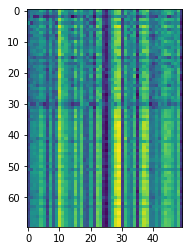

In [130]:
# Sort theo user_group + draw sigmoid/softmax layer
k =70
a = group_scores
ind = np.argmax(group_scores, axis=1)
plt.imshow( a[np.argsort(ind)][0:k] )

In [131]:
# np.argsort(a[1])

In [132]:
# [np.isin(np.argsort(a[1]), np.array([0,1,2]) )]

In [133]:
# Vẽ theo user_group
# user_groups = [ 32 ]
# a = group_scores
# ind = np.argmax(group_scores, axis=1)
# plt.imshow( a[ np.isin( ind, user_groups)] )

In [134]:
# Vẽ y_true của các user chung group
# y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()
# y_true_ugrs = y_true[ np.isin( ind, user_groups)]

# for i in range(y_true_ugrs.shape[0]):
#     y_true_i = y_true_ugrs[i].reshape((50,100))
#     print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
#     plt.imshow( y_true_i)
#     plt.show()


In [135]:
# plt.imshow(y_true[0].reshape(50, 100) )

In [136]:
# y_true[0][y_true[0]!=0]

In [137]:
# y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()[0:15]
# for i in range(y_true.shape[0]):
#     y_true_i = y_true[i].reshape((50,100))
#     print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
#     plt.imshow( y_true_i)
#     plt.show()

In [138]:
# for i in range(group_scores.shape[0]):
#     plt.imshow( group_scores[i].numpy().reshape((5,10)) )
#     plt.show()

In [139]:
# plt.imshow(y_true)

In [140]:
gc.collect()

751